In [1]:
import numpy as np
from gpflowopt.domain import ContinuousParameter
import matplotlib.pyplot as plt
import gpflow
from gpflowopt.bo import BayesianOptimizer
from gpflowopt.design import LatinHyperCube,FactorialDesign,RandomDesign
from gpflowopt.acquisition import ExpectedImprovement
from gpflowopt.optim import SciPyOptimizer, StagedOptimizer, MCOptimizer
import torch
import time 


In [2]:
def gramacy(x):
    a = np.sin(10.*np.pi*x)/(2.*x)
    b = (x-1.)**4.
    ret= a+b
    return ret

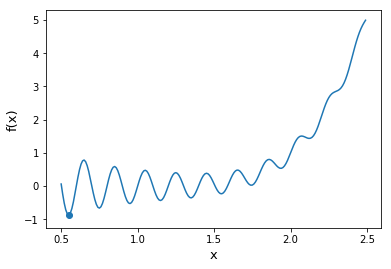

In [3]:
xxx = np.arange(0.5,2.5,0.01)
plt.plot(xxx,gramacy(xxx))
plt.ylabel('f(x)',size=13) 
plt.xlabel('x',size=13) 
#plt.title('Gramacy & Lee function')
plt.xticks(np.arange(0.5,2.6, 0.5))
x=0.5485
y=gramacy(x)
plt.scatter(x,y)
plt.savefig("gramacy.pdf",bbox_inches="tight")
plt.show()

In [4]:
gramacy(0.5485)

-0.8690093239456621

In [5]:
domain = ContinuousParameter('x1', 0.5, 2.5)

lhd = RandomDesign(2, domain)
step=18

In [6]:
#min_all = torch.load('min_all_gramacy.pt')
#len(min_all)

In [7]:
min_all=[]
t0 = time.time()
for n in range(1):
    print('Iteration:',n)
    X = lhd.generate()
    Y = gramacy(X)
    model = gpflow.gpr.GPR(X, Y, gpflow.kernels.RBF(1, ARD=True,variance=0.1))
    model.kern.lengthscales.transform = gpflow.transforms.Log1pe(1e-3)

    # Now create the Bayesian Optimizer
    alpha = ExpectedImprovement(model)
    #MCOptimizer(domain, 200)
    acquisition_opt = StagedOptimizer([MCOptimizer(domain, 200),SciPyOptimizer(domain)])
    optimizer = BayesianOptimizer(domain, alpha, optimizer=acquisition_opt, verbose=True)
    
    t1 = time.time()
    # Run the Bayesian optimization
    r = optimizer.optimize(gramacy, n_iter=step)
    print(r)
    print('time : {:.02e} seconds'.format(time.time() - t1))
    min_all.append(np.minimum.accumulate(alpha.data[1][:,0]))
    
    
t2=time.time() - t0
print('time : {:.02e} seconds'.format(time.time() - t0))

Iteration: 0
iter #  0 - MLL [-3.84] - fmin [0.152]
iter #  1 - MLL [-4.78] - fmin [0.152]
iter #  2 - MLL [-6.32] - fmin [0.0609]
iter #  3 - MLL [-8.05] - fmin [0.0609]
iter #  4 - MLL [-8.61] - fmin [0.0609]
iter #  5 - MLL [-9.87] - fmin [-0.434]
iter #  6 - MLL [-12.2] - fmin [-0.434]
iter #  7 - MLL [-13.1] - fmin [-0.434]
iter #  8 - MLL [-11.9] - fmin [-0.434]
iter #  9 - MLL [-12.2] - fmin [-0.434]
iter # 10 - MLL [-10.8] - fmin [-0.434]
iter # 11 - MLL [-11.9] - fmin [-0.434]
iter # 12 - MLL [-11.7] - fmin [-0.434]
iter # 13 - MLL [-11.6] - fmin [-0.434]
iter # 14 - MLL [-11.7] - fmin [-0.434]
iter # 15 - MLL [-11.2] - fmin [-0.434]
iter # 16 - MLL [-11.2] - fmin [-0.434]
iter # 17 - MLL [-7.49] - fmin [-0.434]
 constraints: array([], dtype=float64)
         fun: array([-0.43444636])
     message: 'OK'
        nfev: 18
     success: True
           x: array([[1.14928874]])
time : 1.25e+01 seconds
time : 1.29e+01 seconds


In [8]:
sum_step=0
for i in range(len(min_all)):
    sum_step=sum_step+ np.minimum.accumulate(min_all[i])

In [9]:
min_step =sum_step/len(min_all)
sum2=0
for i in range(len(min_all)):
    sum2=sum2+np.minimum.accumulate(min_all[i])**2

var=sum2/len(min_all)-min_step**2

In [10]:
std=(var/len(min_all))**0.5

In [11]:
#min_step = np.load('min_step_gramacy.npy')
#std = np.load('std_gramacy.npy')

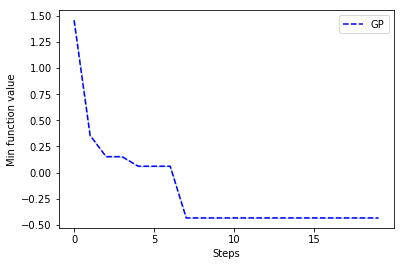

In [12]:
steps=20
plt.plot(min_step,'b--',label='GP')
plt.xticks(np.arange(0, steps, 5))
plt.fill_between(np.arange(0, steps, 1), min_step - 2*std, min_step +2*std,color="C0", alpha=0.3) 

plt.legend(loc='upper right')
plt.ylabel('Min function value') 
plt.xlabel('Steps') 
#plt.ylim(-1.5,1)
plt.show()

In [13]:
min_step[-1]

-0.43444636169040024

In [14]:
#np.save('min_step_gramacy.npy',min_step)
#np.save('std_gramacy.npy',std)

In [15]:
#torch.save(min_all, open('min_all_gramacy.pt', 'wb'))
#min_all = torch.load('min_all_gramacy.pt')